In [3]:
import pandas as pd
import networkx as nx
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import scipy.stats as sp
import collections
import networkx as nx
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import matplotlib.pyplot as plt
import json

In [4]:
# Load edges (Graph connections)
edges = pd.read_csv("musae_facebook_edges.csv")

# Load features (Node features)
with open("musae_facebook_features.json") as f:
    features = json.load(f)

# Load target (Node labels)
targets = pd.read_csv("musae_facebook_target.csv")

In [ ]:
# first few rows
print("Edges:")
print(edges.head())

print("\nTargets:")
print(targets.head())

Edges:
   id_1   id_2
0     0  18427
1     1  21708
2     1  22208
3     1  22171
4     1   6829

Targets:
   id       facebook_id                                     page_name  \
0   0   145647315578475                      The Voice of China 中国好声音   
1   1      191483281412                 U.S. Consulate General Mumbai   
2   2   144761358898518                                          ESET   
3   3   568700043198473  Consulate General of Switzerland in Montreal   
4   4  1408935539376139             Mark Bailey MP - Labor for Miller   

    page_type  
0      tvshow  
1  government  
2     company  
3  government  
4  politician  


EDGES
This represents the connections between Facebook pages. Each row (id_1, id_2) is an edge in the network.
Example: The first row means that Node 1 is connected to Node 18427.

TARGETS
Each row represents a Facebook page (node).
facebook_id: A unique identifier for each page.
page_name: The name of the page.
page_type: The category it belongs to, like:
tvshow
government
company
politician

Degree Distribution Summary:
count    22470.000000
mean        15.220472
std         26.414431
min          1.000000
25%          3.000000
50%          7.000000
75%         17.000000
max        709.000000
dtype: float64


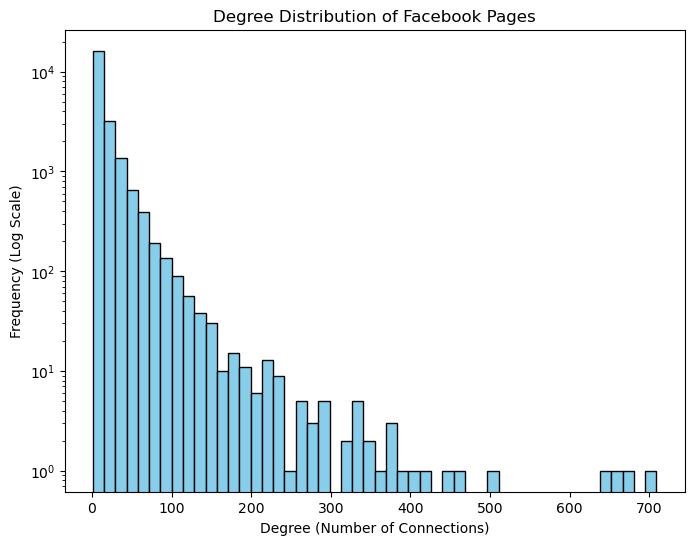

In [6]:
# Build Graph
G = nx.Graph()
G.add_edges_from(edges.values)

# Compute Degree for each node
degree_dict = dict(G.degree())
degree_series = pd.Series(degree_dict)

# Basic Stats
print("Degree Distribution Summary:")
print(degree_series.describe())

# Plot Degree Histogram
plt.figure(figsize=(8, 6))
plt.hist(degree_series, bins=50, color='skyblue', edgecolor='black', log=True)
plt.xlabel("Degree (Number of Connections)")
plt.ylabel("Frequency (Log Scale)")
plt.title("Degree Distribution of Facebook Pages")
plt.show()


the graph is highly skewed - most nodes have a very low degree,
most nodes have <10 connections

In [7]:
print(f"Number of Nodes: {G.number_of_nodes()}")
print(f"Number of Edges: {G.number_of_edges()}")
print(f"Graph Density: {nx.density(G):.4f}")


Number of Nodes: 22470
Number of Edges: 171002
Graph Density: 0.0007


the denisty suggests that most nodes are not directly connected 

Exploring features:

In [8]:

# Check Feature Size
num_nodes = len(features)
num_features = len(next(iter(features.values())))  # First node's features

print(f"Total Nodes in Features: {num_nodes}")
print(f"Each Node has {num_features} Features")

Total Nodes in Features: 22470
Each Node has 22 Features


In [14]:
# Print first node's features
first_node_id = list(features.keys())[0]
print("First node's features:", features[first_node_id])


First node's features: [2835, 4518, 2198, 2014, 3818, 3045, 4570, 4585, 4596, 4599, 4609, 4617, 4627, 4641, 4643, 4651, 4665, 4676, 4682, 4694, 4696, 4708]


High vs Low degree:

In [ ]:
# Define High-Degree and Low-Degree Thresholds
high_degree_threshold = degree_series.quantile(0.90)  # Top 10% most connected nodes
low_degree_threshold = degree_series.quantile(0.10)   # Bottom 10% least connected nodes

high_degree_nodes = degree_series[degree_series >= high_degree_threshold].index
low_degree_nodes = degree_series[degree_series <= low_degree_threshold].index

print(f"High-degree Nodes: {len(high_degree_nodes)}")
print(f"Low-degree Nodes: {len(low_degree_nodes)}")


High-degree Nodes: 2328
Low-degree Nodes: 2658


The top 10% (high-degree nodes) represent the most connected entities, while the bottom 10% (low-degree nodes) show the least connected.The two groups are close in size (2,328 vs. 2,658) - balanced comparison

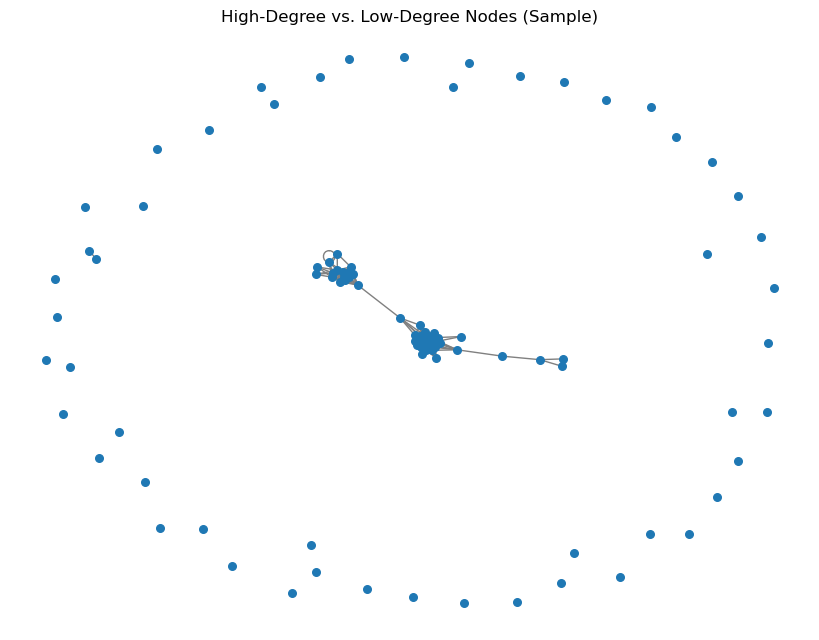

In [10]:
# Subgraph for Visualization
subgraph_nodes = list(high_degree_nodes)[:50] + list(low_degree_nodes)[:50]
subG = G.subgraph(subgraph_nodes)

plt.figure(figsize=(8, 6))
nx.draw(subG, node_size=30, edge_color="gray")
plt.title("High-Degree vs. Low-Degree Nodes (Sample)")
plt.show()


50 high-degree nodes (most connected)
50 low-degree nodes (least connected)

- Densely connected core in the center
- isolated nodes in the peripheral 

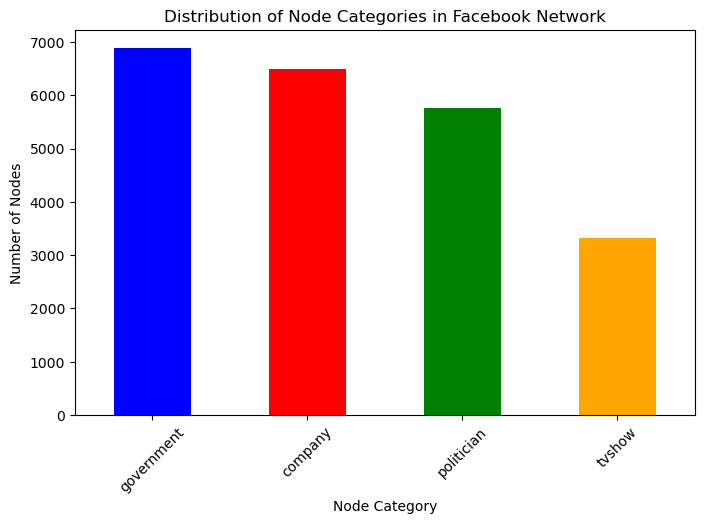

In [11]:
# Load node categories
targets = pd.read_csv("musae_facebook_target.csv")

# Count occurrences of each category
category_counts = targets['page_type'].value_counts()

# Plot Bar Chart
plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color=['blue', 'red', 'green', 'orange'])
plt.xlabel("Node Category")
plt.ylabel("Number of Nodes")
plt.title("Distribution of Node Categories in Facebook Network")
plt.xticks(rotation=45)
plt.show()


Government pages (~7,000 nodes) and Companies (~6,500 nodes) are the most common.
Politicians (~5,500 nodes) are slightly fewer.
TV Shows (~3,000 nodes) are the least represented.

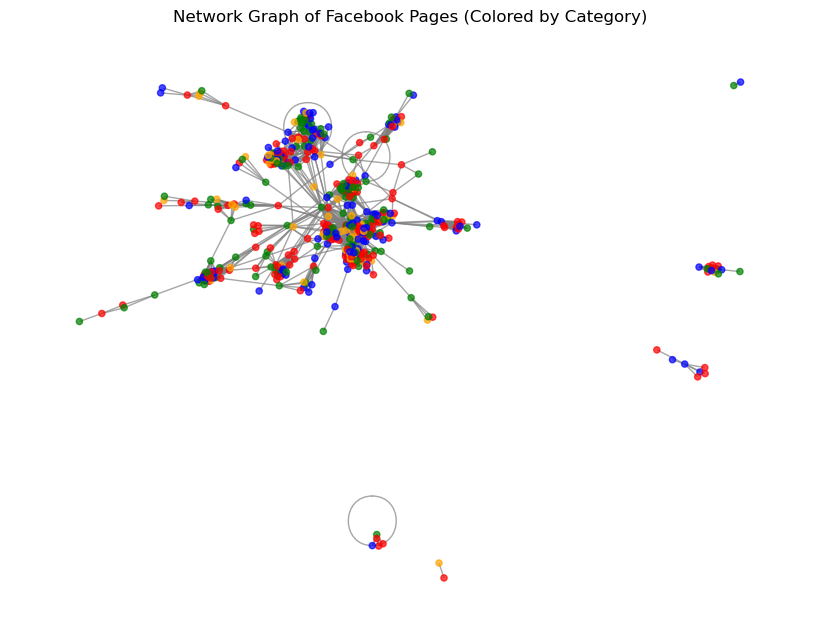

In [13]:
# Create a graph
edges = pd.read_csv("musae_facebook_edges.csv")
G = nx.Graph()
G.add_edges_from(edges.values)

# Define colors for categories
category_colors = {
    "politician": "blue",
    "government": "red",
    "company": "green",
    "tvshow": "orange"
}

# Assign node colors
node_colors = [category_colors.get(cat, "gray") for cat in targets['page_type']]

# Sample a subgraph for visualization (Too large to plot everything)
subG = G.subgraph(list(G.nodes)[:500])  # Adjust sample size if needed

plt.figure(figsize=(8, 6))
nx.draw(subG, node_size=20, node_color=node_colors[:500], edge_color="gray", alpha=0.7)
plt.title("Network Graph of Facebook Pages (Colored by Category)")
plt.show()



"politician" - blue
"government" - red
"company"- green
"tvshow" - orange

well-mixed categories